# **Data-Intensive Computing Project**

**By: Kailin Wu and Christian Durán García**

## **Project Description**

**PROBLEM STATEMENT**

Customer churn is a real life problem that is affecting every subscription-like business. In a
world where data is being leveraged in almost every aspect of our lives it is possible to find
patterns and understand in a more profound way why certain people just decide to not
renovate subscriptions for certain services. Finding a way to predict whether a customer will
or will not continue with their subscription may allow businesses to address their strategies
accordingly and take countermeasures against the problem. We are both studying a major in
Engineering in Business Digital Transformation, so, having a set of tools like Spark to
generate predictions suitable for businesses seems like a formidable skill to have our future
involvement in the workforce.

**DATA**

The data we plan to use is in the form of two csv files from Kaggle, located in the next link:
https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset

The data is split into training and test data, and evaluation data. Our intent is to use the
evaluation data for simulating real life cases of customer behavior.

**TOOLS**

- Spark and SparkSQL to pre-process and query the data.
- SparkML to generate machine learning algorithms and make predictions.
- Matplotlib and Seaborn to visualize data for a Exploratory Data Analysis.
- Pandas for compatibility with Matplotlib and Seaborn for EDA.
- Streamlit to present our results in a webapp easy to consume.

**METHODOLOGY**

- Collect and read the data using Spark commands.
- Preprocess data with Spark to generate viable data for analysis.
- Query data with SparkSQL to carry on an Exploratory Data Analysis.
- Generate Spark Pandas DataFrames to use visualization libraries.
- Use training and test data to train a model for churn classification using SparkML.
- Generate predictions with the evaluation data simulating real life cases.
- Visualize the historical and predictive data in an executive webapp.

## **Libraries and Data**

In [40]:
# Spark
from pyspark.sql import SparkSession
import findspark

# Solve problem when importing collections in Python 3.10
import collections.abc
#hyper needs the five following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
collections.Callable = collections.abc.Callable

# Data Libraries
import pandas as pd
from collections.abc import Iterable
import matplotlib.pyplot as plt
import seaborn as sns

# Streamlit
import streamlit as st

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Find spark commands
findspark.init()
findspark.find()

'c:\\Users\\cridu.DESKTOP-SDSTA7L\\anaconda3\\lib\\site-packages\\pyspark'

In [41]:
# Create spark session ans visualize the object
spark = SparkSession.builder.appName('Data-Intensive_Project').getOrCreate()

spark

### Data Dictionary
- **CustomerID:** ID of the customer.
- **Age:** Age of the customer.
- **Gender:** Gender of the customer.
- **Tenure:** Period of time that the customer is subscribed.
- **Usage Frequency;** How often the customer use the service.
- **Support Calls:** Number of calls to the call center.
- **Payment Delay:** Days that payment has been delayed.
- **Subscription Type:** Type of subscription the customer has.
- **Contract Length:** Length of the subscription.
- **Total Spend:** Amount spent during the subscription.
- **Last Interaction:** Days since the last interaction with the service.
- **Churn:** Indicates whether a customer has churned or not, a churned customer is one who has decided to discontinue their subscription.

In [124]:
# Read data from csv file
sdf = spark.read.csv('customer_churn_dataset-training-master.csv', header=True, inferSchema=True)
test_sdf = spark.read.csv('customer_churn_dataset-testing-master.csv', header=True, inferSchema=True)

# Show schema
sdf.printSchema()
test_sdf.printSchema()

# Show first 5 rows
sdf.show(5)
test_sdf.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: integer (nullable = true)
 |-- Last Interaction: integer 

In [127]:
from pyspark.sql.functions import col, count, countDistinct, max

# Describing the whole dataframe
num_cols = [col for col, dtype in sdf.dtypes if dtype in ['int', 'double'] and col not in ['CustomerID', 'Churn']]
cat_cols = [col for col, dtype in sdf.dtypes if dtype not in ['int', 'double']]

# Numerical description
num_desc = sdf.select(num_cols).describe()
num_desc_test = test_sdf.select(num_cols).describe()

# Categorical description
cat_desc = sdf.select(cat_cols).agg(
    *[count(col(col_name)).alias(f'count_{col_name}') for col_name in cat_cols],
    *[countDistinct(col(col_name)).alias(f'unique_{col_name}') for col_name in cat_cols],
    *[max(col(col_name)).alias(f'top_{col_name}') for col_name in cat_cols]
)
cat_desc_test = test_sdf.select(cat_cols).agg(
    *[count(col(col_name)).alias(f'count_{col_name}') for col_name in cat_cols],
    *[countDistinct(col(col_name)).alias(f'unique_{col_name}') for col_name in cat_cols],
    *[max(col(col_name)).alias(f'top_{col_name}') for col_name in cat_cols]
)

# Combined description of the dataframe
description = num_desc.crossJoin(cat_desc)
test_description = num_desc_test.crossJoin(cat_desc_test)

# Show
print('Training dataset')
description.show()
print('Evaluation dataset')
test_description.show()

Training dataset
+-------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------+-----------------------+---------------------+-------------+------------------------+----------------------+----------+---------------------+-------------------+
|summary|               Age|           Tenure|  Usage Frequency|     Support Calls|     Payment Delay|      Total Spend|  Last Interaction|count_Gender|count_Subscription Type|count_Contract Length|unique_Gender|unique_Subscription Type|unique_Contract Length|top_Gender|top_Subscription Type|top_Contract Length|
+-------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------+-----------------------+---------------------+-------------+------------------------+----------------------+----------+---------------------+-------------------+
|  count|            440832|           44

From this statistical description there are some key differences to take into account when it comes to making decision on the Modeling phase:
- *Support Calls:* has a different mean for the evaluation dataset. The mean is much higher, but the standard deviation is rather the same. This could affect the generalization of the models.
- *Payment Delay:* has a similar behavior as Support Calls, in the evaluation dataset the mean is much hgher than in the training dataset.
- *Total Spend:* has a similar behavior in terms of the mean like the previous two features. Other point to stand out is that the standard deviation is relatively higher than in the training dataset, so that means that the values are distributed differently.
- *Last Interaction:* is also higher on the mean, but not as much compared to the previous three features.

## **Data Cleaning**

Dataset is mostly clean due to its nature of a pre-made dataset, but there are still some things we might need to look into before performing any analysis or modeling just yet like:
- Checking for null values.

In [128]:
# Important libraries to perform the following task
from pyspark.sql.functions import isnan, when

# Calculate the number of null values for each column
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdf.columns]).show()

# Calculate the number of null values for each column in the evaluation dataset
test_sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in test_sdf.columns]).show()

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         1|  1|     1|     1|              1|            1|            1|                1|              1|          1|               1|    1|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interactio

Only training dataset has null values that need to be dealt with.

In [129]:
# Defining a function that will help to print out all the rows with null values independently of the column
def get_null_rows(sdf):
    # Condition
    conditions = [col(column).isNull() for column in sdf.columns]
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition = combined_condition | condition

    # Filter df for rows that meet the condition
    null_rows = sdf.filter(combined_condition)

    # Print the number of rows
    print('Number of rows with at least one null value:', null_rows.count())

    # Return rows with null values
    return null_rows

# Display the null rows
get_null_rows(sdf).show()

Number of rows with at least one null value: 1
+----------+----+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID| Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+----+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|      null|null|  null|  null|           null|         null|         null|             null|           null|       null|            null| null|
+----------+----+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



As it can be seen from the output of the previous cell, there is only one null row that has at least one null value. This row has null values for all the columns in the dataset, so, as it is for now, the best way to handle the null values is to simply drop them.

In [130]:
# Dropping null row
sdf = sdf.na.drop()

#  Checking if the operation is successful
get_null_rows(sdf).show()

Number of rows with at least one null value: 0
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



Now that the dataset is fairly clean and does not contain any type of values that may hinder any further analysis, we can procceed to realize the Exploratory Data Analysis.

## **EDA (Exploratory Data Analysis)**

**OVERALL DESCRIPTION FOR THE EXPLORATORY DATA ANALYSIS**

The analysis will be divided in to two main categories:
- Numerical Columns
- Categorical Columns

For each of these categories, some global analysis will be performed, then particular analysis to each variable.

For each relevant numerical variable:
- Descriptive statistics
- Correlations
- Distribution
- Related variables

For each relevant categorical variable:
- Counts
- Unique values
- Related variables
- Creation of categories

### _Numerical Variables_

In [132]:
# Getting a dataframe only with numerical columns
num_cols = [column[0] for column in sdf.dtypes if column[1] in ['int', 'double'] and column[0] != 'CustomerID']

num_sdf = sdf.select(num_cols)
test_num_sdf = test_sdf.select(num_cols)

print(num_sdf.columns)
print(test_num_sdf.columns)

['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']
['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']


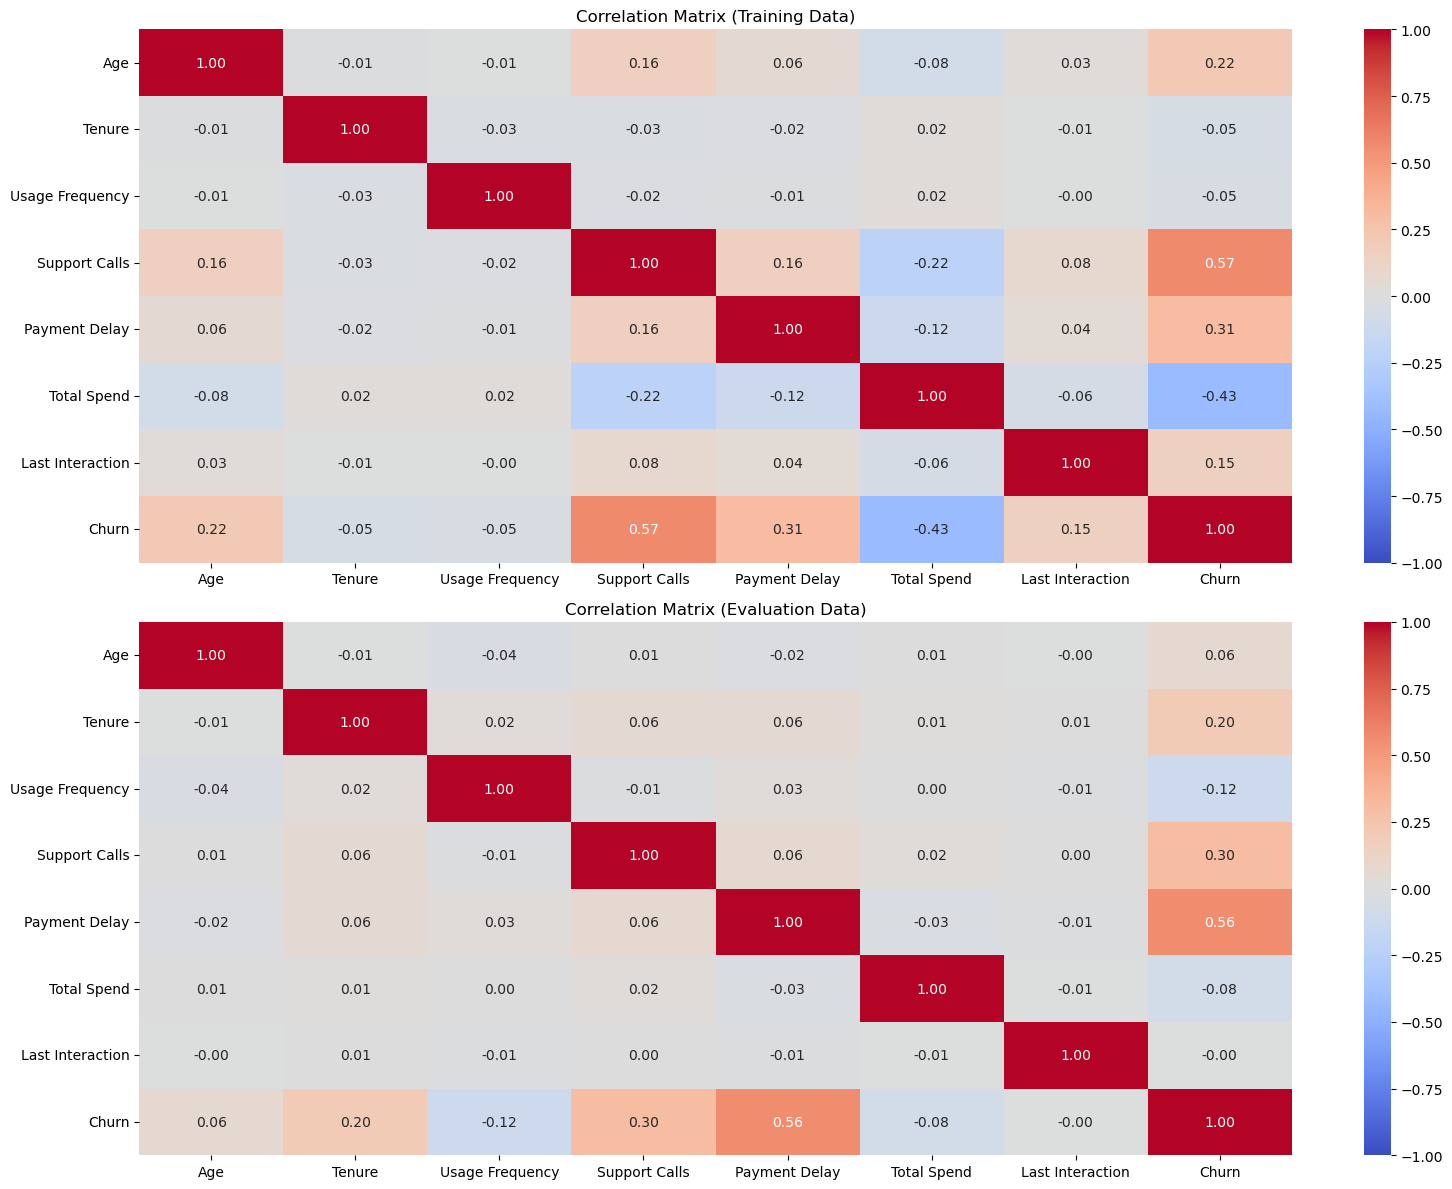

In [139]:
# Function to perform the correlation matrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Creating the vector assembler with the selected columns
vec_assembler = VectorAssembler(inputCols=num_cols, outputCol='features')

# Transform the data into the desired features
num_sdf_transformed = vec_assembler.transform(num_sdf)
test_num_sdf_transformed = vec_assembler.transform(test_num_sdf)

# Calculate the correlation matrix
correlations = Correlation.corr(num_sdf_transformed, 'features').collect()[0][0]
test_correlations = Correlation.corr(test_num_sdf_transformed, 'features').collect()[0][0]

# Convert the PySpark dense matrix to a Python List
corr_matrix = correlations.toArray().tolist()
test_corr_matrix = test_correlations.toArray().tolist()

# Create a Pandas DataFrame from the list
corr_matrix_df = pd.DataFrame(corr_matrix, columns=num_cols, index=num_cols)
test_corr_matrix_df = pd.DataFrame(test_corr_matrix, columns=num_cols, index=num_cols)

# Visualize the correlation matrix using seaborn and matplotlib
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, ax=ax[0])
ax[0].set_title("Correlation Matrix (Training Data)")

sns.heatmap(test_corr_matrix_df, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, ax=ax[1])
ax[1].set_title("Correlation Matrix (Evaluation Data)")

plt.tight_layout()
plt.show()

From this starting point it seems that most of the numerical variables seem to not be related at all in a linear way for both Training and Evaluation data.

**Training Data**

Two correlations that might be worth looking into are the Churn / Support Cals and Churn / Total Spend.

- Churn / Support Calls has a positive correlation stronger than 0.50, it's not much but with some interpretation we can conclude that seems plausible that a customer is more likely to churn if they need a lot of support from client service.
- Churn / Total Spend has a negative correlation weaker than 0.40, it's not much as well but there can be some connection between users that do not spend much in their subscription and churning.

**Evaluation Data**

The correlations are significantly different than in the training dataset.

- Tenure / Churn appear to be slightly related, where in the training dataset them seem to be completely unrelated.
- Age / Churn have less correlation than in the training dataset, where they seem to be slighly correlated.
- Support Calls / Churn and Payment Delay / Churn seem to have switched places in terms of the magnitude of its correlation.
- Total Spend / Churn now seem to have less of a negative correlation, where in the training dataset they had a relatively significant negative correlation.

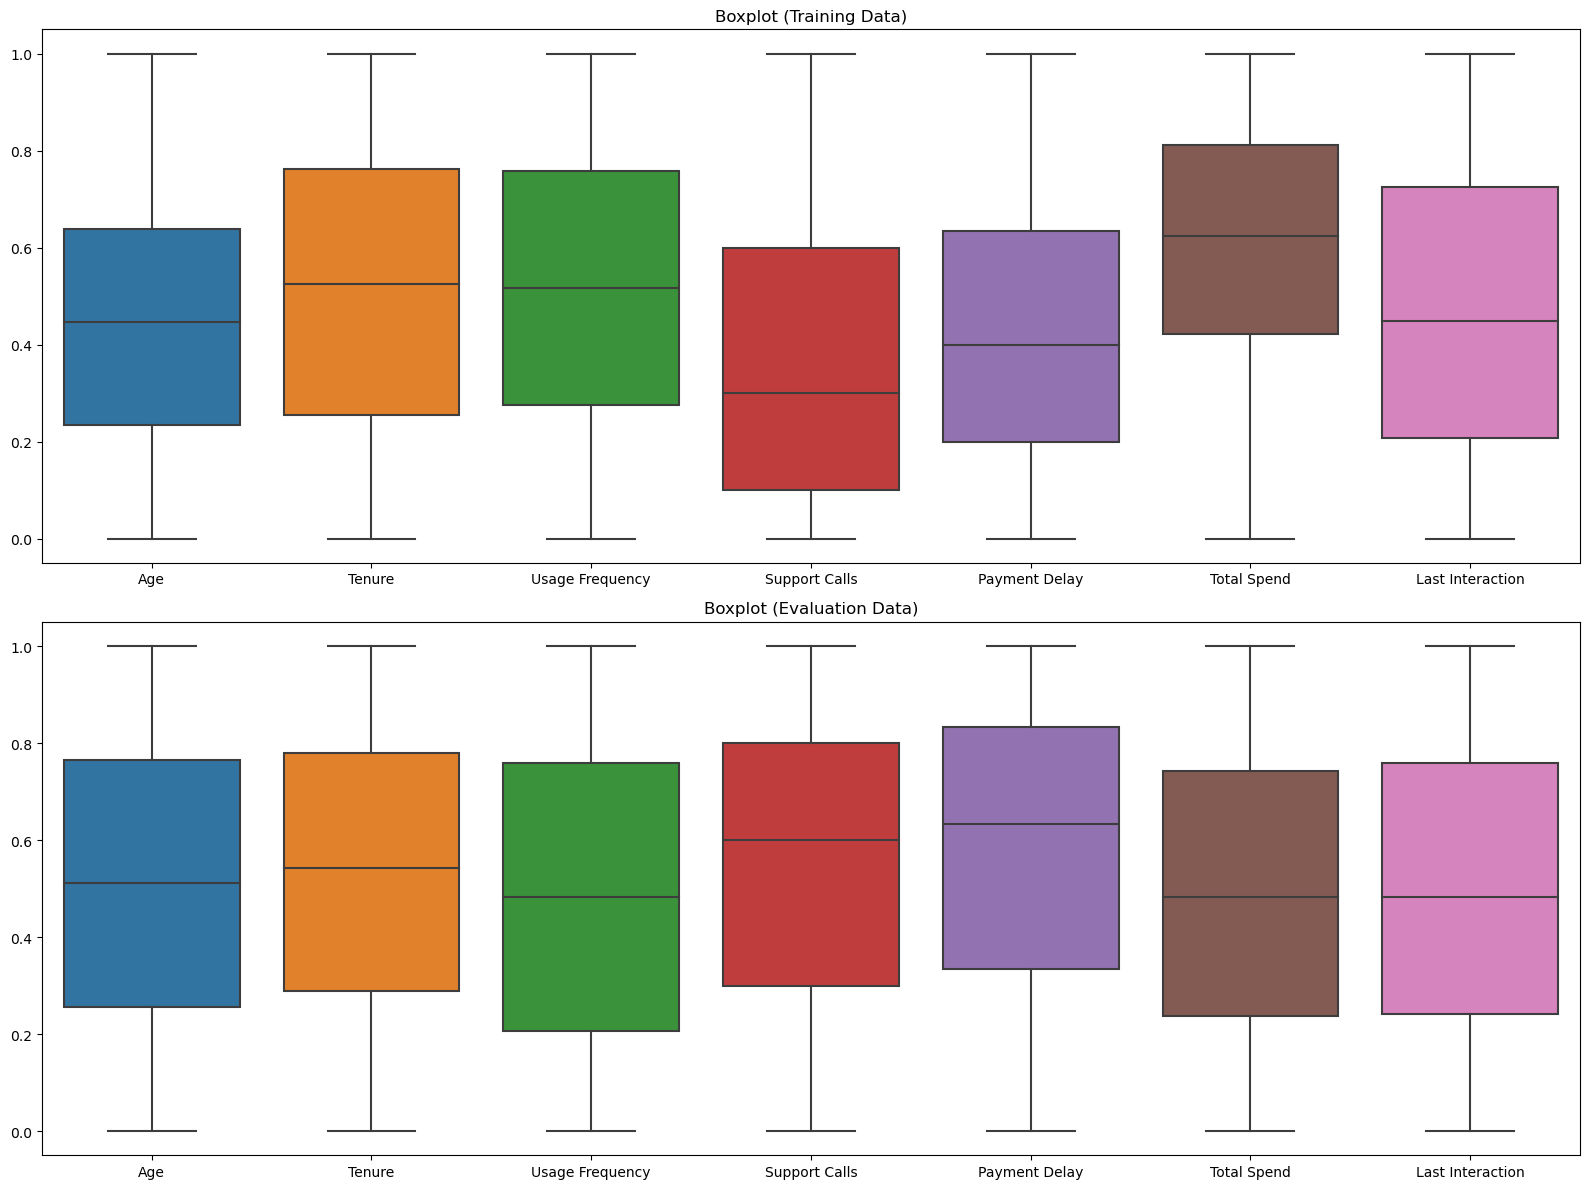

In [151]:
# Visualizing the numerical features in a boxplot, need to use a StandardScaler
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

vect = VectorAssembler(inputCols=num_cols, outputCol='features')
vect_num_sdf = vect.transform(num_sdf)
test_vect_num_sdf = vect.transform(test_num_sdf)

scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
scaled_model = scaler.fit(vect_num_sdf)
scaled_sdf = scaled_model.transform(vect_num_sdf)
test_scaled_sdf = scaled_model.transform(test_vect_num_sdf)

scaled_data = scaled_sdf.select('scaled_features').toPandas()
test_scaled_data = test_scaled_sdf.select('scaled_features').toPandas()

data_for_plot = pd.DataFrame(scaled_data['scaled_features'].tolist(), columns=num_cols)
test_data_for_plot = pd.DataFrame(test_scaled_data['scaled_features'].tolist(), columns=num_cols)

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.boxplot(data_for_plot.drop('Churn', axis=1), ax=ax[0])
ax[0].set_title("Boxplot (Training Data)")

sns.boxplot(test_data_for_plot.drop('Churn', axis=1), ax=ax[1])
ax[1].set_title("Boxplot (Evaluation Data)")

plt.tight_layout()
plt.show()

For performing this visualization we decided to use a StandardScaler transformer to put all the data into a single scale and be able to compare it to the other numerical variables. The main insights from this chart are:

**Training Data**

- _Age_: Most of the values are concentrated from the middle backwards of the data distribution, so **many customers are young people.**
- _Tenure_: This variable has a fairly **standard distribution.**
- _Usage Frequency_: The **same** as Tenure.
- _Support Calls_: Most of the data are concentrated in the lesser values, meaning that **most of the clients do not make many Support Calls**.
- _Payment Delay_: The same as Support Calls, meaning that **most clients tend to delay few days before paying**.
- _Total Spend_: Most data points fall in the middle upwards part of the distribution, menaning that most of the **customers spend relatively good amounts of money in their service**.
- _Last Interaction_: Follows a fairly **standard distribution.**

**Evaluation Data**

This plot allows for the observation of how the data follows the same insights we found doing the describe method previously.

Now, we can perform this same task excluiding the Churn vairables and instead making a filter with it. This way we can compare the boxplots for both the custumers that churned and the ones who didn't.

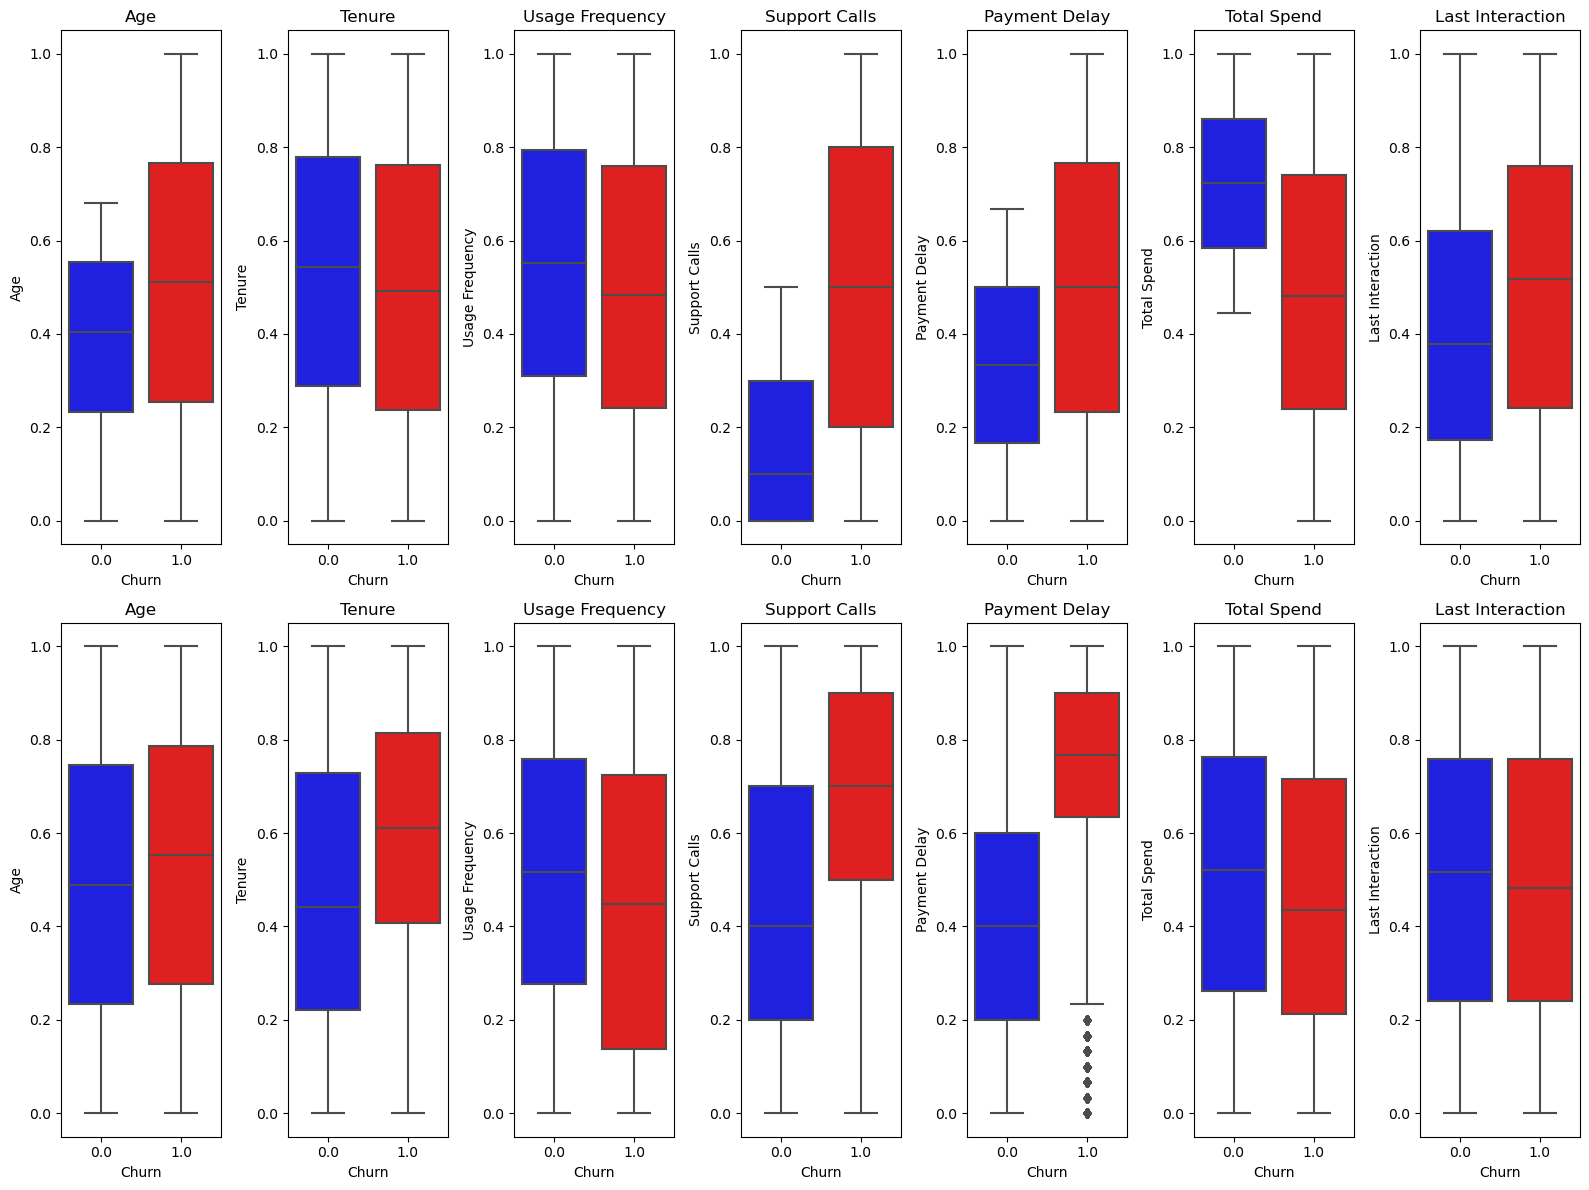

In [153]:
# Plotting each one of them in a separate boxplot in order to compare them
fig, ax = plt.subplots(2, 7, figsize=(16,12))

for i, column in enumerate(num_cols[:-1]):
    sns.boxplot(x='Churn', y=column, data=data_for_plot, palette={0:'blue', 1:'red'}, ax=ax[0,i])
    ax[0,i].set_title(column)

    sns.boxplot(x='Churn', y=column, data=test_data_for_plot, palette={0:'blue', 1:'red'}, ax=ax[1,i])
    ax[1,i].set_title(column)
    
plt.tight_layout()
plt.show()

This comparison is rather interesting and allows us to see which features differ the most in churned and not churned customers.

**Training Data**

- **Churned customers tend to be younger**, whereas the not churned customers are older.
- **Tenure, Usage Frequency, Payment Delay, and Last Interaction variables are much more concentrated towards the mean for not churned customer**s, churned cusotmers have a more disperse behavior.
- **Churned customers make more support calls than not churned ones**, this last group have the mean close to zero, meaning that **most of the customers that renovate the service make little to no support calls**.
- Finally, **not churned customers have a total spend much higher than churned customer**s, if fact the mean spend form not churned customers is higher than the highest spend from the churned customers. This can mean that **not churned customers have loyal to the service for quite some time, where the churned customers only try the service for a spacified period and decide to not renovate it**.

**Evaluation Data**

- **Not churned customers Age is more concentrated towards the mean** in comparison to the training data.
- **Not churned customers have a mean Tenure lower** in comparison to the training data.
- **Not churned customers have a higher mean Support Calls** whereas in training data the not churned clients have a mean closer to the minimum.
- **Churned customers have a higher mean in Payment Delay and much of the data is concentrated towards the mean, also it has some outliers**, in the training data the mean is much lower and the data are not as concentrated and no outliers are visible.
- **Not churned customers Total Spend feature has a lower mean and is more spreaded** than in the training data, where it has a much higher mean and much data is concentrated towards the mean.
- **Last Interaction is relatively the same for all cases**.

From this boxplots is clear to see that there are several differences in the Not Churned Class, label 0. Their behavior is somewhat different between training and evaluation datasets. It may be interesting to investigate different ways to diminish this differences through some feature engineering in order to not miss a lot of label 0 class when training and evaluating the models. **From this point we can infer that the recall f the models will be somewhat poor because the characteristics of class label 0 are different in training and might not be able to generalize well into the evaluation data.**

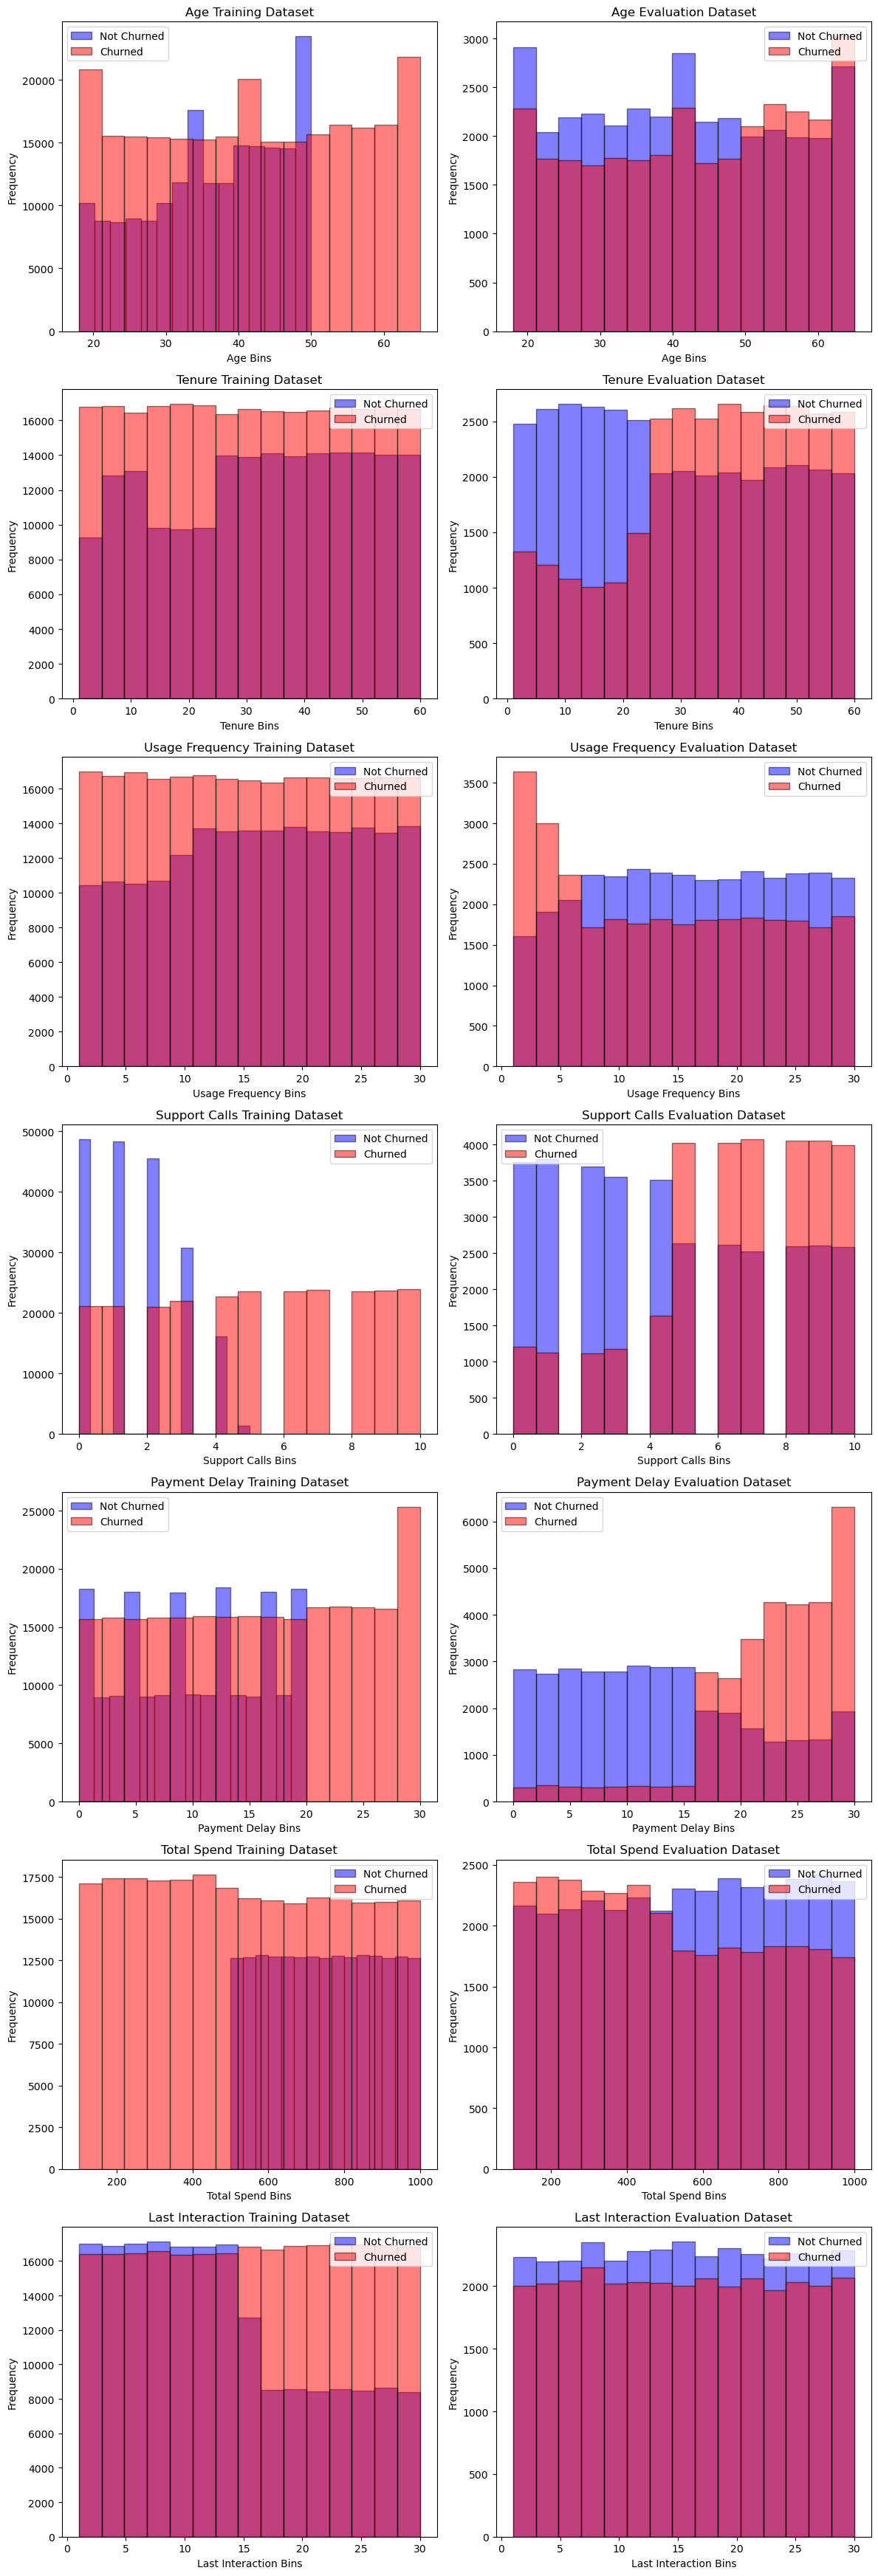

In [179]:
# Visualize the distribution of variables in histograms
fig, ax = plt.subplots(7, 2, figsize=(12,5*7))

for i, col in enumerate(num_cols[:-1]):
    ax[i][0].hist(x=num_sdf.filter('Churn == 0').select(col).toPandas(), bins=15, edgecolor='black', color='blue', alpha=0.5, label='Not Churned')
    ax[i][0].hist(x=num_sdf.filter('Churn == 1').select(col).toPandas(), bins=15, edgecolor='black', color='red', alpha=0.5, label='Churned')
    ax[i][0].set_title(col + ' Training Dataset')
    ax[i][0].legend()
    ax[i][0].set_xlabel(col + ' Bins')
    ax[i][0].set_ylabel('Frequency')

    ax[i][1].hist(x=test_num_sdf.filter('Churn == 0').select(col).toPandas(), bins=15, edgecolor='black', color='blue', alpha=0.5, label='Not Churned')
    ax[i][1].hist(x=test_num_sdf.filter('Churn == 1').select(col).toPandas(), bins=15, edgecolor='black', color='red', alpha=0.5, label='Churned')
    ax[i][1].set_title(col + ' Evaluation Dataset')
    ax[i][1].legend()
    ax[i][1].set_xlabel(col + ' Bins')
    ax[i][1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### _Categorical Variables_

In [183]:
# Getting a dataframe only with categorical columns
cat_cols = [column[0] for column in sdf.dtypes if column[1] not in ['int', 'double']] + ['Churn']

cat_sdf = sdf.select(cat_cols)
test_cat_sdf = test_sdf.select(cat_cols)

test_cat_sdf.show(5)
cat_sdf.show(5)

+------+-----------------+---------------+-----+
|Gender|Subscription Type|Contract Length|Churn|
+------+-----------------+---------------+-----+
|Female|            Basic|        Monthly|    1|
|Female|         Standard|        Monthly|    0|
|  Male|          Premium|         Annual|    0|
|  Male|          Premium|      Quarterly|    0|
|Female|         Standard|         Annual|    0|
+------+-----------------+---------------+-----+
only showing top 5 rows

+------+-----------------+---------------+-----+
|Gender|Subscription Type|Contract Length|Churn|
+------+-----------------+---------------+-----+
|Female|         Standard|         Annual|    1|
|Female|            Basic|        Monthly|    1|
|Female|            Basic|      Quarterly|    1|
|  Male|         Standard|        Monthly|    1|
|  Male|            Basic|        Monthly|    1|
+------+-----------------+---------------+-----+
only showing top 5 rows



#### Gender

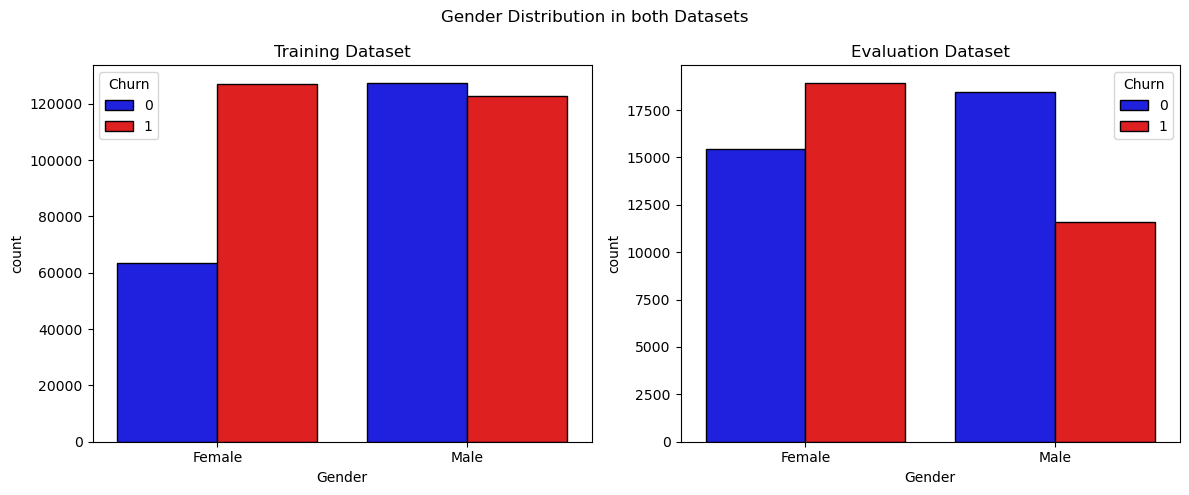

In [186]:
# Check the gender distribution for churned and not churned clients
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.countplot(x='Gender', data=cat_sdf.toPandas(), hue='Churn', palette={0:'blue', 1:'red'}, ax=ax[0], edgecolor='black')
ax[0].set_title('Training Dataset')

sns.countplot(x='Gender', data=test_cat_sdf.toPandas(), hue='Churn', palette={0:'blue', 1:'red'}, ax=ax[1], edgecolor='black')
ax[1].set_title('Evaluation Dataset')

plt.suptitle('Gender Distribution in both Datasets')
plt.tight_layout()
plt.show()

From this couple of barchart it is possible to start noticing some differences between datasets.
- **The proportion of not churned females in the training dataset is smaller compare to the test**.
- **The proportion of churned males is significantly lower in the test dataset**. 

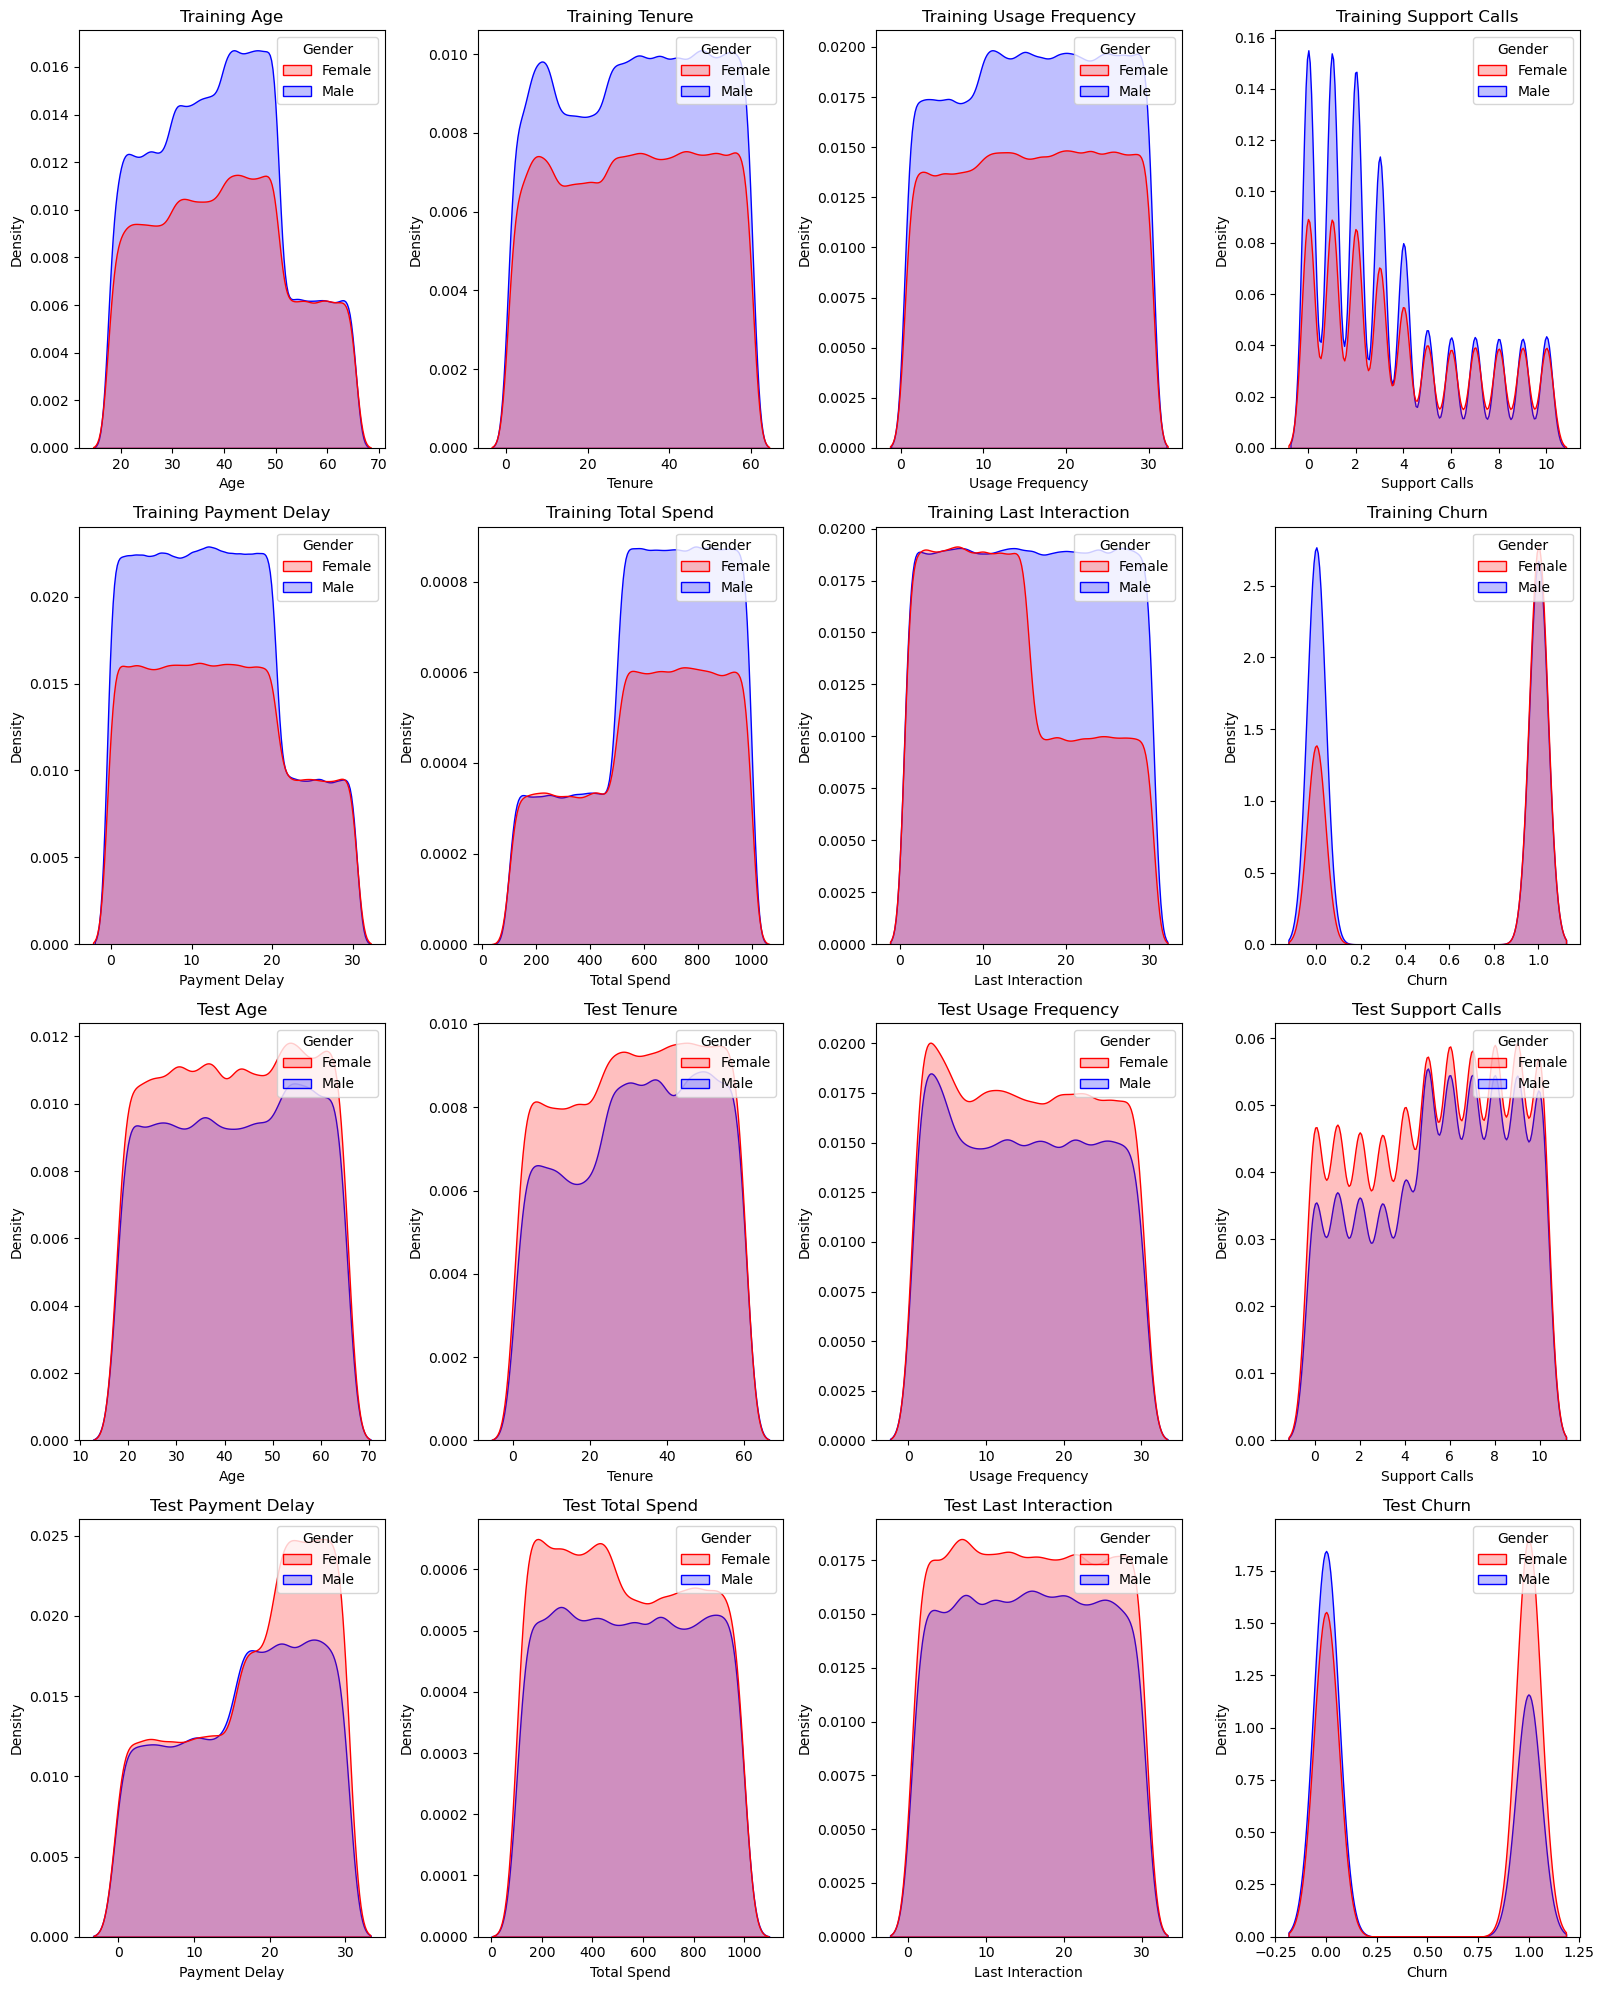

In [202]:
# Comparison with numerical variables
sdf_pd = sdf.toPandas()
test_sdf_pd = test_sdf.toPandas()

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,20))

for i, column in enumerate(num_cols):
    row, col = divmod(i,4)
    test_row, test_col = divmod(i+8,4)

    ax = axes[row, col]
    test_ax = axes[test_row, test_col]

    sns.kdeplot(data=sdf_pd, x=column, hue='Gender', fill=True, ax=ax, palette={'Female':'red', 'Male':'blue'})
    ax.set_title('Training ' + column)
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

    sns.kdeplot(data=test_sdf_pd, x=column, hue='Gender', fill=True, ax=test_ax, palette={'Female':'red', 'Male':'blue'})
    test_ax.set_title('Test ' + column)
    test_ax.set_xlabel(column)
    test_ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

The distribuition between the data of male and female are very similar in most of the numerical variables.

**Training Data**

- The most common age is between 50-55 for both gender.
- There're two highest tenure between both gender, the first one is approximately 10, which can be infer as the first subscription. And the second one is between 55-60, who are satisfied customers of the service.
- Both usage frequency are between 10-30.
- The highest amount of support calls are between 0 and 2.
- Payment Delay can be between 0 to 20 days.
- The total spend are between 300-900.
- There's a difference of last interaction between both gender, the last interaction of female are between 0 and 15, and for male are 0-30.
- Most of the female decide to discontinue the service, and for male can be continue or discontinue.

**Evaluation Data**

- For the Evaluation data the distribution of the Genders compared to the other variables is completely different. The main difference is that mostly there are more females in the evaluation dataset, where in the training there are more males.
- Some distributions are completely the opposite, such is the case of Payment Delay. Where in the Training data the concentration of most values ranges from 0-20, in the Evaluation data it ranges mostly from 20 to 30. We can conclude that in the training data there are more people that are late in their payment.
- Other distributions, like Total Spend, are much more "steady" in the Evaluation data, whereas in the training data the density is skewed towards high values for both genders.

The main takaway is that even though the distributions of the variables are different in both datasets, the behavior of both Females and Males in both datasets is similar respective to their dataset. The distribution if the numerical values is more concerned to their particular features not so much to a gender, aka categorical problem.

#### Subscription Type

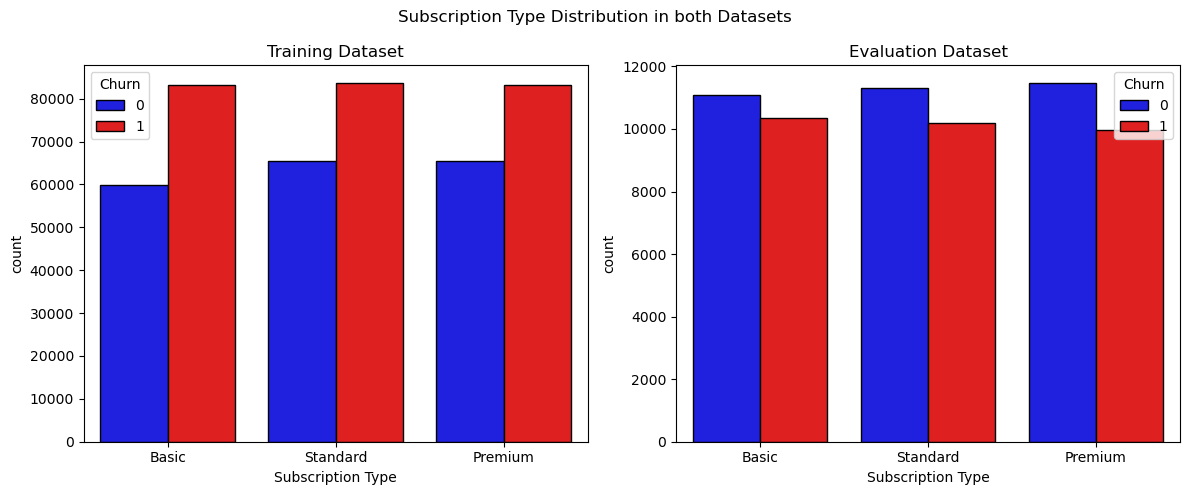

In [204]:
# Bar plot of subscription type
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.countplot(x='Subscription Type', data=cat_sdf.toPandas(), hue='Churn', palette={0:'blue', 1:'red'}, ax=ax[0], edgecolor='black', 
              order=['Basic', 'Standard', 'Premium'])
ax[0].set_title('Training Dataset')

sns.countplot(x='Subscription Type', data=test_cat_sdf.toPandas(), hue='Churn', palette={0:'blue', 1:'red'}, ax=ax[1], edgecolor='black',
              order=['Basic', 'Standard', 'Premium'])
ax[1].set_title('Evaluation Dataset')

plt.suptitle('Subscription Type Distribution in both Datasets')
plt.tight_layout()
plt.show()

It is clear to see how the main takeout from these plots is that in the training dataset most of the subscription types are for the clients that churned, in the other we see how most values go for the not churned clients.

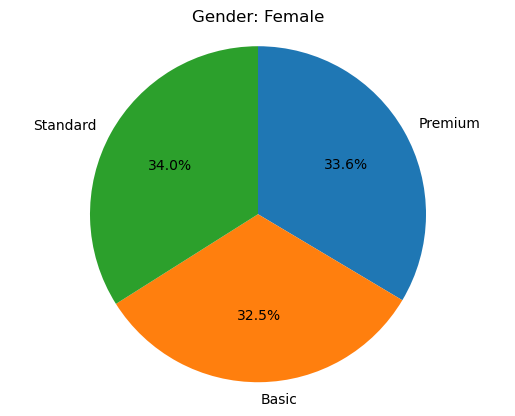

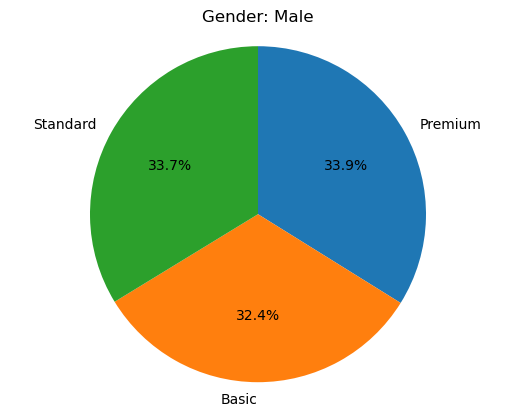

In [65]:
# Get unique subscription types
genders = sdf.select('Gender').distinct().rdd.flatMap(lambda x: x).collect()

# Create a pie chart for each subscription type
for gender in genders:
    # Filter data for the current subscription type
    subset_df = sdf.filter(sdf['Gender'] == gender)

    # Group by Gender and count occurrences
    gender_counts = subset_df.groupBy('Subscription Type').count().toPandas()

    # Create a pie chart
    labels = gender_counts['Subscription Type']
    sizes = gender_counts['count']

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False)

    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Gender: {gender}')

plt.show()

The amount between the 3 types of subscriptions are quite similar and their behavior with the numerical values.

#### Contract Length

In [208]:
# Counts of subscription type
cat_sdf.groupBy('Contract Length').count().show()
test_cat_sdf.groupBy('Contract Length').count().show()

+---------------+------+
|Contract Length| count|
+---------------+------+
|         Annual|177198|
|      Quarterly|176530|
|        Monthly| 87104|
+---------------+------+

+---------------+-----+
|Contract Length|count|
+---------------+-----+
|         Annual|21410|
|      Quarterly|20834|
|        Monthly|22130|
+---------------+-----+



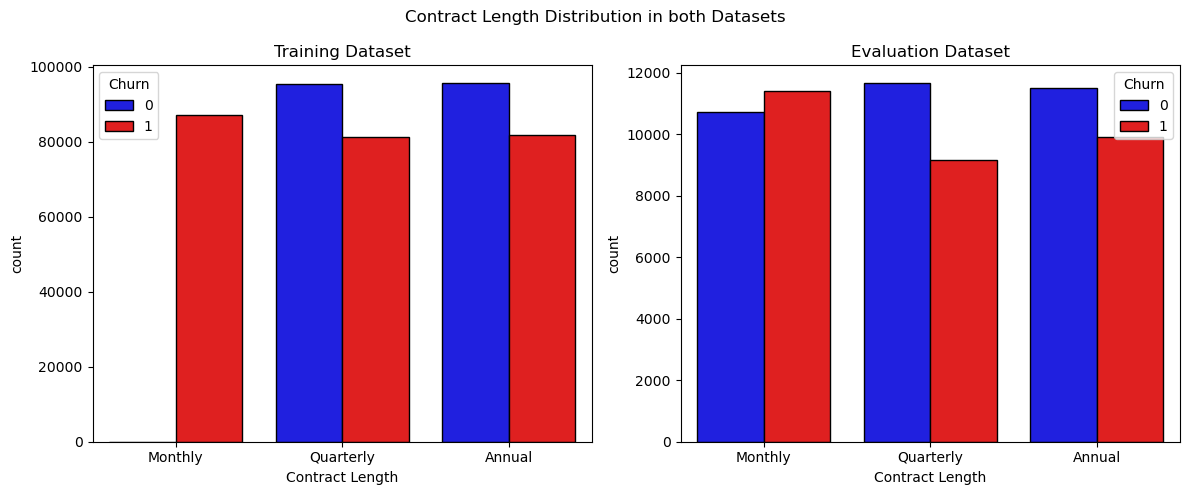

In [212]:
# Bar plot of contract length type
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.countplot(x='Contract Length', data=cat_sdf.toPandas(), hue='Churn', palette={0:'blue', 1:'red'}, ax=ax[0], edgecolor='black', 
              order=['Monthly', 'Quarterly', 'Annual'])
ax[0].set_title('Training Dataset')

sns.countplot(x='Contract Length', data=test_cat_sdf.toPandas(), hue='Churn', palette={0:'blue', 1:'red'}, ax=ax[1], edgecolor='black',
              order=['Monthly', 'Quarterly', 'Annual'])
ax[1].set_title('Evaluation Dataset')

plt.suptitle('Contract Length Distribution in both Datasets')
plt.tight_layout()
plt.show()

There is a huge concern with this variable. **In the Training dataset there are no Monthly clients that dind't churned**, this might take a toll in the classification efforts for not churned clients with a Monthly Contract Length

In [68]:
from pyspark.sql import functions as F

# Define age ranges and labels
age_ranges = [(18, 30), (31, 40), (41, 50), (51, 65)]
labels = ['18-30', '31-40', '41-50', '51-65']

# Create a new column 'AgeGroup' based on age ranges
sdf_with_age_group = sdf.withColumn('AgeGroup', 
                                    F.when((F.col('Age') >= age_ranges[0][0]) & (F.col('Age') <= age_ranges[0][1]), labels[0])
                                    .when((F.col('Age') >= age_ranges[1][0]) & (F.col('Age') <= age_ranges[1][1]), labels[1])
                                    .when((F.col('Age') >= age_ranges[2][0]) & (F.col('Age') <= age_ranges[2][1]), labels[2])
                                    .when((F.col('Age') >= age_ranges[3][0]) & (F.col('Age') <= age_ranges[3][1]), labels[3])
                                    .otherwise('Unknown'))

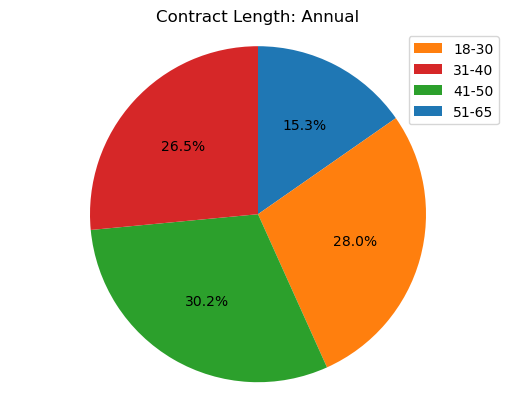

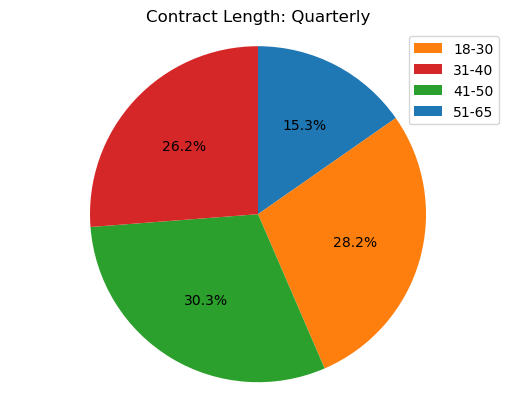

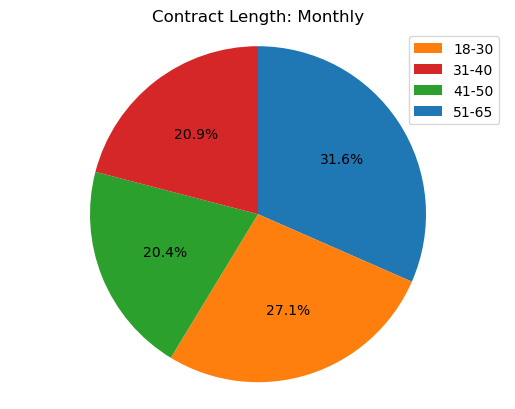

In [69]:
# Get unique subscription types
contracts = sdf_with_age_group.select('Contract Length').distinct().rdd.flatMap(lambda x: x).collect()

# Customer order
label_order = ['18-30', '31-40', '41-50', '51-65']

# Create a pie chart for each subscription type
for contract in contracts:
    # Filter data for the current subscription type
    subset_df = sdf_with_age_group.filter(sdf['Contract Length'] == contract)

    # Group by Gender and count occurrences
    contract_counts = subset_df.groupBy('AgeGroup').count().toPandas()

    # Create a pie chart
    labels = contract_counts['AgeGroup'].tolist()
    sizes = contract_counts['count']

    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, autopct='%1.1f%%', startangle=90, counterclock=False)

    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Contract Length: {contract}')

    # Create custom legend with the correct order
    handles = [wedges[labels.index(label)] for label in label_order]
    labels = label_order
    ax.legend(handles, labels)

plt.show()

## **Modeling**

Now that we have studied the dataset and got a sense of its data distribution and how they are related to one another, and have an idea of the characteristics of both churned and not churned , we can take our next step and try to build a classifier that generalizes the best to the evaluation dataset that contains around 50% of the amount of data available in the training dataset.

To achieve this task we are going to build several classifiers and test them independently to find the one that generalizes the most with the evaluation set. The steps for each classification experiment are:
- Preprocess the data so that it can be fed into each classifier.
- Use a Cross-Validation technique in order to find the model with the best accuracy.
- Use a custom-made function to score the model

### *Data Preprocessing and Feature Selection*

In [70]:
# Size of data
print('Number of rows:', sdf.count())
print('Number of columns:', len(sdf.columns), '\n')

# Show schema
sdf.printSchema()

# Show first 5 rows
sdf.show(5)

Number of rows: 440832
Number of columns: 12 

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+

In [71]:
# Size of data
print('Number of rows:', test_sdf.count())
print('Number of columns:', len(test_sdf.columns), '\n')

# Show schema
test_sdf.printSchema()

# Show first 5 rows
test_sdf.show(5)

Number of rows: 64374
Number of columns: 12 

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: integer (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+

It is clear that we need to drop the CustomerID column in order to procceed with the modeling phase, as this column is just a particular identifier for each customer and doens't carry any relevant information.

In [101]:
# Dropping the CustomerID column in both training and testing dfs
sdf = sdf.drop('CustomerID')
test_sdf = test_sdf.drop('CustomerID')

sdf.printSchema()
test_sdf.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: integer (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)



In [102]:
# Importing relevant libraries for ML experiments
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Numerical columns, not considering churn or customerID
numerical_cols = [column[0] for column in sdf.dtypes if column[1] in ['int', 'double'] and column[0] not in ['CustomerID', 'Churn']]

# Categorical columns
categorical_cols = [column[0] for column in sdf.dtypes if column[1] == 'string']

# Create a numerical vector assembler
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features')

# Scaling numerical features
numerical_scaler = StandardScaler(inputCol='numerical_features', outputCol='scaled_features')

# Create a StringIndexer for each of the categorical columns
categorical_index = [StringIndexer(inputCol=col, outputCol=col+'_index') for col in categorical_cols]

# OneHotEncode the StringIndexed columns
categorical_ohe = [OneHotEncoder(inputCol=col+'_index', outputCol=col+'_ohe') for col in categorical_cols]

# Categorical assember
categorical_assembler = VectorAssembler(inputCols=[col+'_ohe' for col in categorical_cols], outputCol='categorical_ohe_features')

# Final assembler
assembler = VectorAssembler(inputCols=['scaled_features', 'categorical_ohe_features'], outputCol='features')

# Creating the pipeline
preprocessing = Pipeline(stages=[numerical_assembler, numerical_scaler] + categorical_index + categorical_ohe 
                         + [categorical_assembler, assembler])

# Fit pipeline to training data
preprocessing_pipeline = preprocessing.fit(sdf)

# Preprocessing the training dataframe
model_df = preprocessing_pipeline.transform(sdf).select(['features', 'Churn']).withColumnRenamed('Churn', 'label')

# Splitting into training and testing
train_df, test_df = model_df.randomSplit([0.8, 0.2], seed=42)

# Preprocessing the test dataframe
eval_df = preprocessing_pipeline.transform(test_sdf).select(['features', 'Churn']).withColumnRenamed('Churn', 'label')

### *Model Selection and Experimentation*

In [103]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
from pyspark.sql.functions import round
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Creating a custom function to emulate a classification_report from sklearn
def binary_classification_report(predictions, labelCol="label", predictionCol="prediction"):
    # Calculate true positives, true negatives, false positives, and false negatives
    tp = predictions.filter((predictions[labelCol] == 1) & (predictions[predictionCol] == 1)).count()
    tn = predictions.filter((predictions[labelCol] == 0) & (predictions[predictionCol] == 0)).count()
    fp = predictions.filter((predictions[labelCol] == 0) & (predictions[predictionCol] == 1)).count()
    fn = predictions.filter((predictions[labelCol] == 1) & (predictions[predictionCol] == 0)).count()

    # Calculate precision, recall, and F1-score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate support for each class
    pos_support = tp + fn
    neg_support = tn + fp

    # Calculate overall accuracy
    total_predictions = predictions.count()
    accuracy = (tp + tn) / total_predictions

    # Define the schema for the report DataFrame
    schema = StructType([
        StructField("label", IntegerType(), True),
        StructField("precision", DoubleType(), True),
        StructField("recall", DoubleType(), True),
        StructField("f1-score", DoubleType(), True),
        StructField("support", IntegerType(), True),
        StructField("accuracy", DoubleType(), True)
    ])

    # Create a list of data rows
    report_data = [(0, tn/(tn + fn), tn/(tn + fp), 2*(tn/(tn+fn)*tn/(tn+fp))/(tn/(tn+fn)+tn/(tn+fp)), neg_support, None),
                   (1, precision, recall, f1_score, pos_support, None),
                   (None, None, None, None, total_predictions, accuracy)]

    # Create the DataFrame with the specified schema
    report_df = spark.createDataFrame(report_data, schema)

    # Round up number up to two decimal points
    for col in report_df.columns:
        report_df = report_df.withColumn(col, round(report_df[col], 2))

    return report_df

# Creating a custom function to plot a confusion matrix based on the predictions of a binary classifier
def plot_confusion_matrix(predictions, labelCol="label", predictionCol="prediction"):
    # Calculate true positives, true negatives, false positives, and false negatives
    tp = predictions.filter((predictions[labelCol] == 1) & (predictions[predictionCol] == 1)).count()
    tn = predictions.filter((predictions[labelCol] == 0) & (predictions[predictionCol] == 0)).count()
    fp = predictions.filter((predictions[labelCol] == 0) & (predictions[predictionCol] == 1)).count()
    fn = predictions.filter((predictions[labelCol] == 1) & (predictions[predictionCol] == 0)).count()

    # Elaborate the confusion matrix
    cm = np.array([[tn, fp],
                   [fn, tp]])
    
    # Plot the confusion matrix
    matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
    matrix_plot.plot();
    plt.title('Confusion Matrix');

#### **LogisticRegression**

In [104]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Creating Model
lr = LogisticRegression()

# Parameter grid for logistic regression
lr_grid = (ParamGridBuilder()\
           .addGrid(lr.regParam, [0.1, 0.01, 0.001])\
            .build())

# Evaluator for Cross Validation
evaluator = BinaryClassificationEvaluator()

# Cross Validation
crossval = CrossValidator(estimator=lr, estimatorParamMaps=lr_grid, evaluator=evaluator, numFolds=5)

# Model and predictions
lr_model = crossval.fit(train_df)
lr_predictions = lr_model.transform(test_df)

# Print out report
binary_classification_report(lr_predictions).show()

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.86|  0.91|    0.88|  38315|    null|
|    1|     0.93|  0.89|    0.91|  49911|    null|
| null|     null|  null|    null|  88226|     0.9|
+-----+---------+------+--------+-------+--------+



Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

<Figure size 800x500 with 0 Axes>

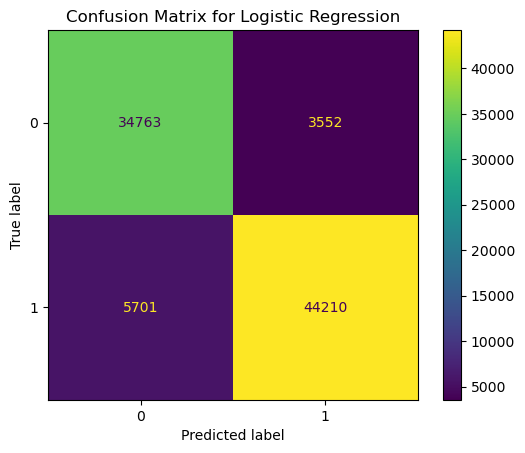

In [105]:
# Plotting the confusion matrix for logistic regression
plt.figure(figsize=(8,5))
plot_confusion_matrix(lr_predictions)
plt.title('Confusion Matrix for Logistic Regression')

In [106]:
# Getting the best hyperparameter for logistic classifier
best_lr_model = lr_model.bestModel
best_reg_param = best_lr_model.getOrDefault('regParam')
print('Best hyperparameter: ', best_reg_param)

Best hyperparameter:  0.001


#### **RandomForestClassifier**

In [107]:
from pyspark.ml.classification import RandomForestClassifier

# Creating Model
rf = RandomForestClassifier()

# Parameter grid for logistic regression
rf_grid = (ParamGridBuilder()\
           .addGrid(rf.maxDepth, [3, 5, 10])\
            .build()) # Relatively low depth to have simpler model

# Evaluator for Cross Validation
evaluator = BinaryClassificationEvaluator()

# Cross Validation
crossval = CrossValidator(estimator=rf, estimatorParamMaps=rf_grid, evaluator=evaluator, numFolds=5)

# Model and predictions
rf_model = crossval.fit(train_df)
rf_predictions = rf_model.transform(test_df)

# Print out report
binary_classification_report(rf_predictions).show()

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.98|   1.0|    0.99|  38315|    null|
|    1|      1.0|  0.98|    0.99|  49911|    null|
| null|     null|  null|    null|  88226|    0.99|
+-----+---------+------+--------+-------+--------+



Text(0.5, 1.0, 'Confusion Matrix for Random Forest')

<Figure size 800x500 with 0 Axes>

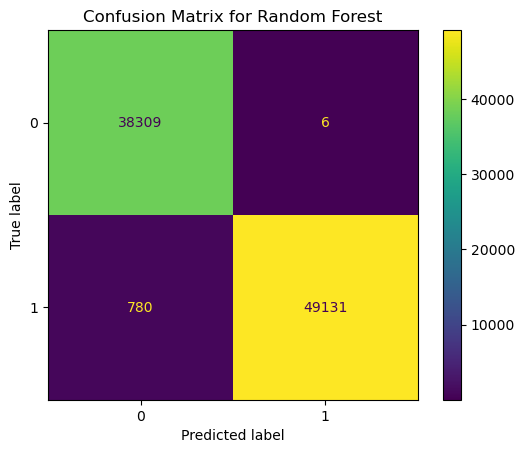

In [108]:
# Plotting the confusion matrix for Random Forest
plt.figure(figsize=(8,5))
plot_confusion_matrix(rf_predictions)
plt.title('Confusion Matrix for Random Forest')

In [109]:
# Getting the best hyperparameter for random forest classifier
best_rf_model = rf_model.bestModel
best_maxDepth_param = best_rf_model.getOrDefault('maxDepth')
print('Best hyperparameter: ', best_maxDepth_param)

Best hyperparameter:  10


#### **NaiveBayes**

In [110]:
from pyspark.ml.classification import NaiveBayes

# Creating Model
nb = NaiveBayes()

# Parameter grid for logistic regression
nb_grid = (ParamGridBuilder()\
           .addGrid(nb.smoothing, [1, 3, 5])\
            .build())

# Evaluator for Cross Validation
evaluator = BinaryClassificationEvaluator()

# Cross Validation
crossval = CrossValidator(estimator=nb, estimatorParamMaps=nb_grid, evaluator=evaluator, numFolds=5)

# Model and predictions
nb_model = crossval.fit(train_df)
nb_predictions = nb_model.transform(test_df)

# Print out report
binary_classification_report(nb_predictions).show()

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.82|  0.85|    0.84|  38315|    null|
|    1|     0.88|  0.86|    0.87|  49911|    null|
| null|     null|  null|    null|  88226|    0.86|
+-----+---------+------+--------+-------+--------+



Text(0.5, 1.0, 'Confusion Matrix for Naive Bayes')

<Figure size 800x500 with 0 Axes>

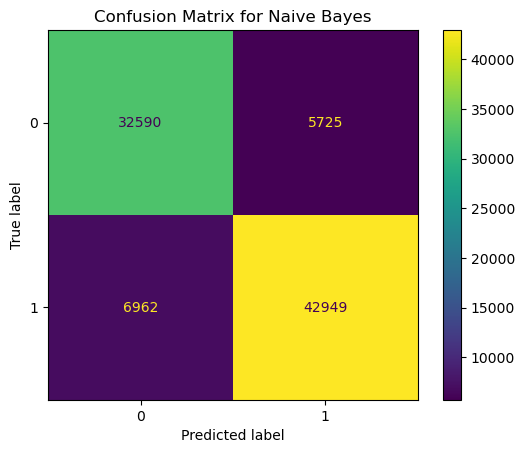

In [111]:
# Plotting the confusion matrix for Naive Bayes
plt.figure(figsize=(8,5))
plot_confusion_matrix(nb_predictions)
plt.title('Confusion Matrix for Naive Bayes')

In [112]:
# Getting the best hyperparameter for naive bayes classifier
best_nb_model = nb_model.bestModel
best_maxDepth_param = best_nb_model.getOrDefault('smoothing')
print('Best hyperparameter: ', best_maxDepth_param)

Best hyperparameter:  1.0


#### **LinearSVC**

In [113]:
from pyspark.ml.classification import LinearSVC

# Creating Model
svc = LinearSVC()

# Parameter grid for logistic regression
svc_grid = (ParamGridBuilder()\
           .addGrid(svc.regParam, [1.0, 0.1, 0.01])\
            .build())

# Evaluator for Cross Validation
evaluator = BinaryClassificationEvaluator()

# Cross Validation
crossval = CrossValidator(estimator=svc, estimatorParamMaps=svc_grid, evaluator=evaluator, numFolds=5)

# Model and predictions
svc_model = crossval.fit(train_df)
svc_predictions = svc_model.transform(test_df)

# Print out report
binary_classification_report(svc_predictions).show()

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.85|  0.92|    0.88|  38315|    null|
|    1|     0.94|  0.87|     0.9|  49911|    null|
| null|     null|  null|    null|  88226|    0.89|
+-----+---------+------+--------+-------+--------+



Text(0.5, 1.0, 'Confusion Matrix for Linear SVC')

<Figure size 800x500 with 0 Axes>

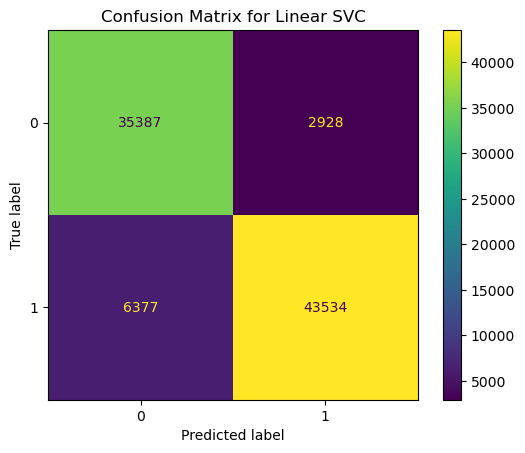

In [116]:
# Plotting the confusion matrix for Linear SVC
plt.figure(figsize=(8,5))
plot_confusion_matrix(svc_predictions)
plt.title('Confusion Matrix for Linear SVC')

In [115]:
# Getting the best hyperparameter for logistic classifier
best_svc_model = svc_model.bestModel
best_reg_param = best_svc_model.getOrDefault('regParam')
print('Best hyperparameter: ', best_reg_param)

Best hyperparameter:  0.01


After performing four experiments we can see how most of the classifiers achieved more than 90% accuracy.

**LogisticRegression** did good with an accuracy of 0.9. It has a tougher time predicting not churn clients as its precision for that label in particular is the most lacking metric.

**RandomForstClassifier** performed much better than LogisticRegression at out first experiment where the depth of each tree in the model was adjusted up to 15, making each DecisionTree very complex. In order to avoid any overfitting in the data we decided to keep the complexity of the trees relatively simple, trying with a maxDepth of 3, 5, and 10; where 10 got the better results.

**NaiveBayes** did not performed really well, we can conclude that this particular classification task is not well suited for a statistical model, all these relatively to the previous models.

**LinearSVC** did almost as good as LogisticRegression. It did worse in predicting not Churned customers, this is depicted by the lower precision for the 0 class label. Also, the regularization parameter that resulted the best after the cross_validation resulted higher than in LogisticRegression, which means that LinearSVC requieres more regularization than the other model in order to better fit the data, meaning that there is a higher probability that the model overvitted the data.

## **Evaluation**

### **Model performance with Evaluation Data** 

In order to verify how well each model generalizes to the evaluation data we can test each of the best models found in training in order to check their ability to achieve this.

#### **LogisticRegression**

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.96|  0.19|    0.32|  33881|    null|
|    1|     0.53|  0.99|    0.69|  30493|    null|
| null|     null|  null|    null|  64374|    0.57|
+-----+---------+------+--------+-------+--------+



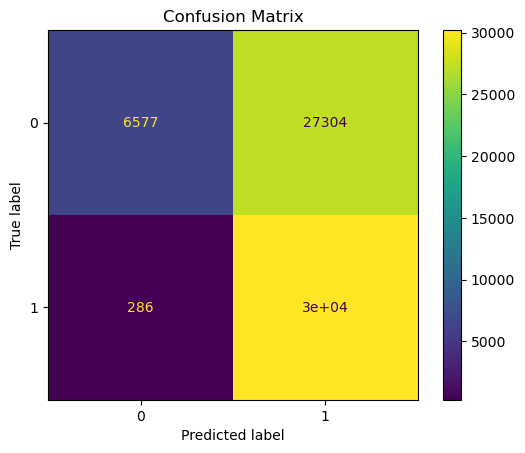

In [120]:
# Making prediction with the best logistic regression model found in triaining
lr_eval_pred = best_lr_model.transform(eval_df)

# Generate report
binary_classification_report(lr_eval_pred).show()

# Generate confusion matrix
plot_confusion_matrix(lr_eval_pred)

#### **RandomForest**

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.98|  0.08|    0.14|  33881|    null|
|    1|     0.49|   1.0|    0.66|  30493|    null|
| null|     null|  null|    null|  64374|    0.51|
+-----+---------+------+--------+-------+--------+



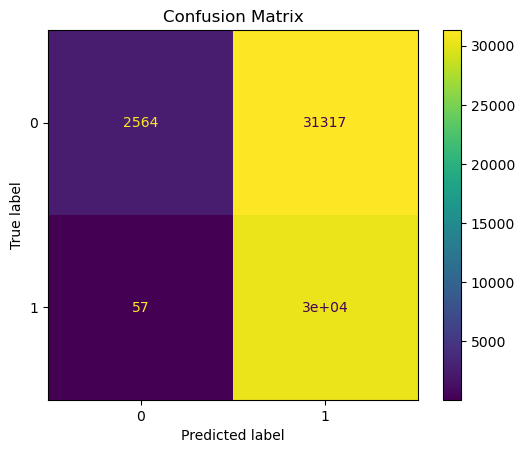

In [121]:
# Making prediction with the best random forest model found in triaining
rf_eval_pred = best_rf_model.transform(eval_df)

# Generate report
binary_classification_report(rf_eval_pred).show()

# Generate confusion matrix
plot_confusion_matrix(rf_eval_pred)

#### **NaiveBayes**

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.97|  0.23|    0.37|  33881|    null|
|    1|     0.54|  0.99|     0.7|  30493|    null|
| null|     null|  null|    null|  64374|    0.59|
+-----+---------+------+--------+-------+--------+



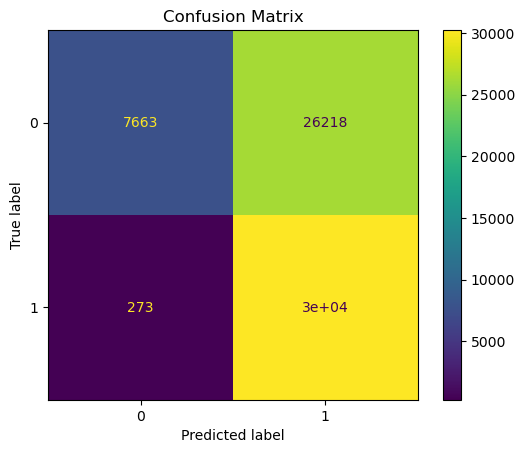

In [122]:
# Making prediction with the best naive bayes model found in triaining
nb_eval_pred = best_nb_model.transform(eval_df)

# Generate report
binary_classification_report(nb_eval_pred).show()

# Generate confusion matrix
plot_confusion_matrix(nb_eval_pred)

#### **LinearSVC**

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.95|  0.21|    0.35|  33881|    null|
|    1|     0.53|  0.99|    0.69|  30493|    null|
| null|     null|  null|    null|  64374|    0.58|
+-----+---------+------+--------+-------+--------+



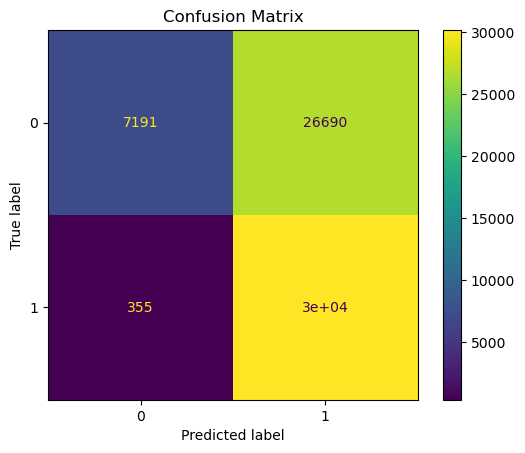

In [123]:
# Making prediction with the best logistic regressionlinear svc model found in triaining
svc_eval_pred = best_svc_model.transform(eval_df)

# Generate report
binary_classification_report(svc_eval_pred).show()

# Generate confusion matrix
plot_confusion_matrix(svc_eval_pred)

As it is clear in both the Binary Classification Report and the Confusion Matrix of all the models. Most of them have a mediocre performance on the evaluation dataset. In matter of fact, **the Naive bayes model**, which had the worst accuracy of them all in the training phase, **achieved the highest accuracy in the evaluation phase**.

Besides, all model has one flaw in particular, they had a tough time predicting the not churn class, label 0; this is evident iin both Confusion Matrices and the recall score for this particular label. **Both Linear Regression and Random Forest had really low recall scores for label 0**, making them the worst in terms of generalizing into new data. On the other hand, **Linear SVC and Naive Bayes models had a better time predicting label 0, but still had bad scores**.

Now, considering the previous interpretation of the evaluation phase we can conclude that the problem is turning into a more boundary / probabilistic type of problem.